In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *
from torch.autograd import Variable
import torch.autograd as autograd
from Adam import Adam
from sklearn.model_selection import train_test_split

torch.manual_seed(0)
np.random.seed(0)

In [2]:
################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)
        
        if x_ft.shape[2] < self.modes1:
            modes1 = x_ft.shape[2]
            weights1 = nn.Parameter(self.scale * torch.rand(self.in_channels, self.out_channels, modes1, dtype=torch.cfloat))

        else: 
            modes1 = self.modes1
            weights1 = self.weights1
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)

        out_ft[:, :, :modes1] = self.compl_mul1d(x_ft[:, :, :modes1], weights1)
        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 20)
        self.fc2 = nn.Linear(20, 1)
        # self.batch_norm1 = nn.BatchNorm1d(self.width)
        # self.batch_norm2 = nn.BatchNorm1d(1024)
        
    def forward(self, x):
        
        flag = 0
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        # if x.shape[2] == 1:
        #    x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic
        #    flag = 1
            
        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.relu(x)
        # x = self.batch_norm1(x)
        
        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.relu(x)
        # x = self.batch_norm1(x)
        
        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.relu(x)
        # x = self.batch_norm1(x)
        
        x1 = self.conv3(x)
        x2 = self.w3(x)
        
        x = x1 + x2
        # if flag == 1:
        #    x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

In [3]:
################################################################
#  configurations
################################################################

batch_size = 10
learning_rate = 0.001

epochs = 500
step_size = 50
gamma = 0.5

modes = 32
width = 64

In [4]:
################################################################
# read data
################################################################

# Data is of the shape (number of samples, grid size)
x = torch.linspace(-1, 1, 200)
t = torch.linspace(0, 1, 200)

# Create the mesh 
x_data , t_data = torch.meshgrid(x, t)

def f_real(x,t):
    return np.sin(np.pi * x) * np.cos(2 * np.pi * t) + 1/2 * np.sin(4 * np.pi * x) * np.cos(8 * np.pi * t)

y_data = f_real(x_data, t_data)

C:\Users\84909\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
x_train, x_test, t_train, t_test, y_train, y_test = train_test_split(x_data, t_data, y_data, test_size=0.1, random_state=42)

In [6]:
x_train = x_train.unsqueeze(dim  = -1)
x_test = x_test.unsqueeze(dim  = -1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=True)

# model
model = FNO1d(modes, width)
print(count_params(model))

1066729


### PINNs

In [7]:
X_IC = torch.hstack((x_data[:,0][:,None], t_data[:,0][:,None])).unsqueeze(dim = -1)
X_IC.shape

torch.Size([200, 2, 1])

In [8]:
Y_IC = (torch.sin(np.pi*X_IC[:, 0]) + 1/2 * torch.sin(4*np.pi*X_IC[:, 0]))
Y_IC.shape

torch.Size([200, 1])

In [9]:
# Lower boundary
X_BC_1 = torch.hstack((x_data[0, :][:,None], t_data[0, :][:,None])).unsqueeze(dim = -1)
X_BC_2 = torch.hstack((x_data[-1, :][:,None], t_data[-1, :][:,None])).unsqueeze(dim = -1)

Y_BC_1 = torch.zeros(len(X_BC_1), 1)
Y_BC_2 = torch.zeros(len(X_BC_2), 1)

# Gom lại thành 1 khối, xếp chồng 3 cái lên nhau
X_C = torch.vstack([X_IC, X_BC_1, X_BC_2])
Y_C = torch.vstack([Y_IC, Y_BC_1, Y_BC_2])

In [10]:
lb = torch.tensor([torch.min(x_data), torch.min(t_data)])
ub = torch.tensor([torch.max(x_data), torch.max(t_data)])

In [11]:
from pyDOE import lhs

Num_collocation = 20000
X_train_collocation = (lb + (ub - lb) *lhs(1, Num_collocation)).unsqueeze(dim = -1)# 2 as the inputs are x and t

In [12]:
X_C = X_C.float() #Training Points (BC)
Y_C = Y_C.float() #Training Points (BC)
X_train_collocation = X_train_collocation.float() #Collocation Points

In [13]:
def lossC(X_C, Y_C):
    
    '''
    X: points on initial & boundary condition. Shape: [sum of points, 1, 1]
    Y: value of X on condtions. Shape: [sum of values, 1] 
    
    Output: MSE Loss on total conditions
    '''
    
    # MSE loss
    return loss_mse(model(X_C).squeeze(dim = -1)[:, 0].reshape(-1, 1), Y_C)

def lossPDE(x_PDE):
    
    f_hat = torch.zeros(x_PDE.shape[0], 1)
    x_PDE.requires_grad=True #Enable differentiation
    
    f = model(x_PDE).squeeze(dim = -1)

    # Đạo hàm bậc 1
    f_x_t = autograd.grad(f, x_PDE, torch.ones([x_PDE.shape[0], 2]).to(device), retain_graph=True, create_graph=True)[0] 
    # Đạo hàm bậc 2
    f_xx_tt = autograd.grad(f_x_t, x_PDE,torch.ones(x_PDE.shape).to(device), create_graph=True)[0]
    f_xx = f_xx_tt[:,[0]]
    f_tt = f_xx_tt[:,[1]]
    # PDE dựa theo đề bài đã cho
    f = (f_tt - 4 * f_xx).squeeze(dim = -1)
    return loss_mse(f, f_hat)

In [14]:
loss_mse = nn.MSELoss(reduction ='mean')

In [16]:
################################################################
# training and evaluation
################################################################
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
z_data_list = []
mse_plot = []

for ep in range(200):
    model.train()
    t1 = default_timer()
    train_mse = 0
    test_mse = 0
    
    for x, y in train_loader:

        optimizer.zero_grad()
        out = model(x)

        mse = loss_mse(out.view(batch_size, -1), y.view(batch_size, -1))
        total_loss = mse #+ 1/10 * (lossC(X_C, Y_C) + lossPDE(X_train_collocation))
        total_loss.backward()

        optimizer.step()
        train_mse = mse.item()
        test_mse = mse.item()

    scheduler.step()
    model.eval()
    
    with torch.no_grad():
        for x, y in test_loader:

            out = model(x)
            test_l2 = loss_mse(out.view(batch_size, -1), y.view(batch_size, -1)).item()
    
    mse_plot.append(train_mse)
    t2 = default_timer()
    if ep % 1 == 0:
        print(f'Step: {ep}, Time: {t2-t1}, train_mse: {train_mse}, test_mse: {test_mse}')
        with torch.no_grad():
            for x, y in train_loader:
                out = model(x)
                z_data = np.array(out)
                z_data_list.append(z_data)

Step: 0, Time: 2.6071995999955107, train_mse: 0.14929281175136566, test_mse: 0.14929281175136566
Step: 1, Time: 2.7126872000080766, train_mse: 0.1018545851111412, test_mse: 0.1018545851111412
Step: 2, Time: 2.8449768999998923, train_mse: 0.04147082567214966, test_mse: 0.04147082567214966
Step: 3, Time: 2.9765678999974625, train_mse: 0.09202971309423447, test_mse: 0.09202971309423447
Step: 4, Time: 2.975303899991559, train_mse: 0.03864853456616402, test_mse: 0.03864853456616402
Step: 5, Time: 2.667533400002867, train_mse: 0.05827268958091736, test_mse: 0.05827268958091736
Step: 6, Time: 2.6363206999958493, train_mse: 0.03050990030169487, test_mse: 0.03050990030169487
Step: 7, Time: 2.6362444999977015, train_mse: 0.03351174667477608, test_mse: 0.03351174667477608
Step: 8, Time: 2.583019500001683, train_mse: 0.022567030042409897, test_mse: 0.022567030042409897
Step: 9, Time: 2.6828349999996135, train_mse: 0.01607070304453373, test_mse: 0.01607070304453373
Step: 10, Time: 2.593663699997705

Step: 82, Time: 3.401297500007786, train_mse: 0.00024340998788829893, test_mse: 0.00024340998788829893
Step: 83, Time: 3.370891800004756, train_mse: 0.00015809685282874852, test_mse: 0.00015809685282874852
Step: 84, Time: 3.403750700003002, train_mse: 0.0001119867229135707, test_mse: 0.0001119867229135707
Step: 85, Time: 3.452489699993748, train_mse: 0.00026992440689355135, test_mse: 0.00026992440689355135
Step: 86, Time: 3.523216500005219, train_mse: 0.00014383747475221753, test_mse: 0.00014383747475221753
Step: 87, Time: 3.5190155999880517, train_mse: 0.00045409429003484547, test_mse: 0.00045409429003484547
Step: 88, Time: 3.5859981999965385, train_mse: 0.00018623020150698721, test_mse: 0.00018623020150698721
Step: 89, Time: 3.5987782000011066, train_mse: 0.00017815473256632686, test_mse: 0.00017815473256632686
Step: 90, Time: 3.6223860000027344, train_mse: 0.00015503734175581485, test_mse: 0.00015503734175581485
Step: 91, Time: 3.7095618000021204, train_mse: 0.00016067229444161057, 

Step: 162, Time: 4.274883499994758, train_mse: 4.881190398009494e-05, test_mse: 4.881190398009494e-05
Step: 163, Time: 4.213676999992458, train_mse: 0.0001737813581712544, test_mse: 0.0001737813581712544
Step: 164, Time: 4.270627899997635, train_mse: 8.83978937054053e-05, test_mse: 8.83978937054053e-05
Step: 165, Time: 4.370106200003647, train_mse: 5.250727554084733e-05, test_mse: 5.250727554084733e-05
Step: 166, Time: 4.258543199990527, train_mse: 4.5236836740514264e-05, test_mse: 4.5236836740514264e-05
Step: 167, Time: 4.2890820000029635, train_mse: 4.15299364249222e-05, test_mse: 4.15299364249222e-05
Step: 168, Time: 4.250303200009512, train_mse: 0.00013128251885063946, test_mse: 0.00013128251885063946
Step: 169, Time: 4.284694100002525, train_mse: 0.00011329984408803284, test_mse: 0.00011329984408803284
Step: 170, Time: 4.231373100003111, train_mse: 4.04450147470925e-05, test_mse: 4.04450147470925e-05
Step: 171, Time: 4.2694463999941945, train_mse: 5.288781540002674e-05, test_mse: 

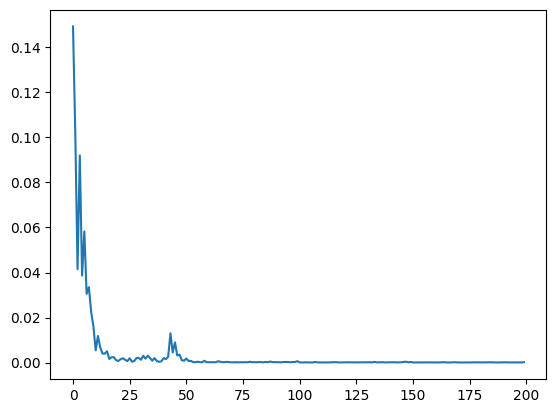

In [17]:
x_coordinate = [i for i in range(len(mse_plot))]

plt.plot(x_coordinate, mse_plot)

In [18]:
def plot3D(X, T, y):
    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(T, X, y,20,cmap="rainbow")
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title('F(x,t)')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()
    ax = plt.axes(projection='3d')
    ax.plot_surface(T.numpy(), X.numpy(), y.numpy(),cmap="rainbow")
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('f(x,t)')
    plt.show()

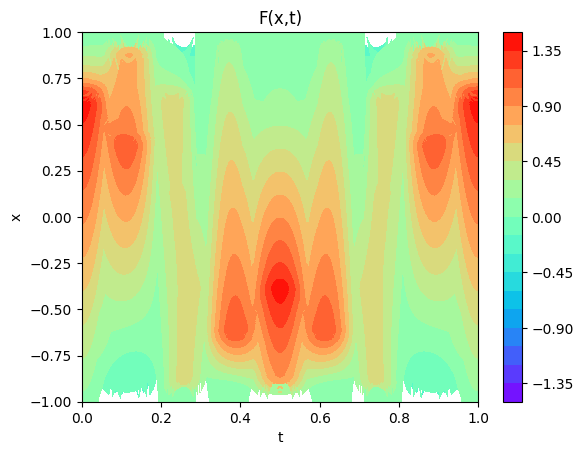

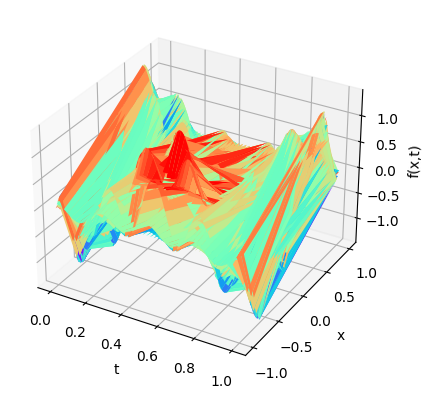

In [19]:
plot3D(x_train.squeeze().detach(), t_train, y_train)

In [20]:
import plotly.graph_objs as go
fig = go.Figure(
    data=[go.Surface(z=z_data_list[0].squeeze())],
    layout=go.Layout(updatemenus=[dict(type="buttons", buttons=[dict(label="Play", method="animate", args=[None])])]),
    frames=[go.Frame(data=[go.Surface(z=k.squeeze())], name=str(i)) for i, k in enumerate(z_data_list)]
)

fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="tomato", project_z=True), colorscale='portland')

fig.update_layout(title='data HEATPILES', autosize=False, width=650, height=500, margin=dict(l=0, r=0, b=0, t=0))

def frame_args(duration):
    return {
            "frame": {"duration": duration},
            "mode": "immediate",
            "fromcurrent": True,
            "transition": {"duration": duration, "easing": "linear"},
        }

sliders = [
            {
                "pad": {"b": 10, "t": 60},
                "len": 0.9,
                "x": 0.1,
                "y": 0,
                "steps": [
                    {
                        "args": [[f.name], frame_args(0)],
                        "label": str(k),
                        "method": "animate",
                    }
                    for k, f in enumerate(fig.frames)
                ],
            }
        ]
    
fig.update_layout(sliders=sliders)
   
import plotly.io as pio

ii = 1
pio.write_html(fig, file="Live3D_"+str(ii)+".html", auto_open=True)

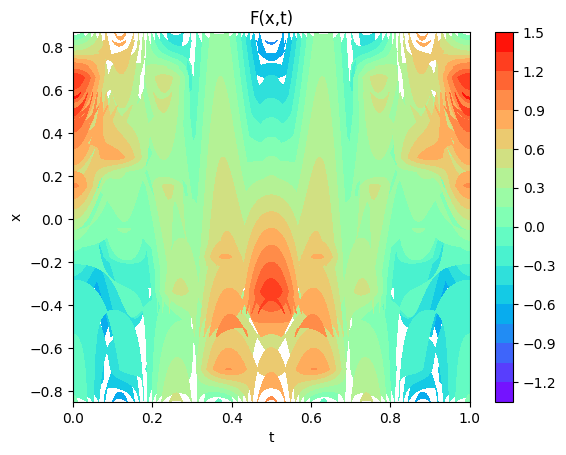

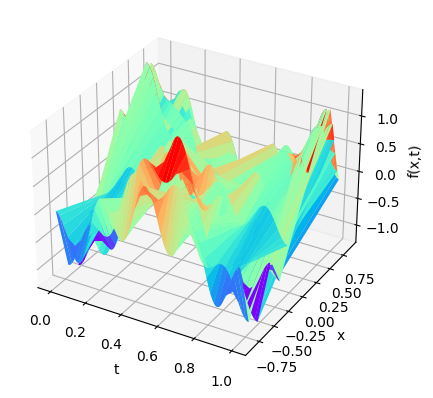

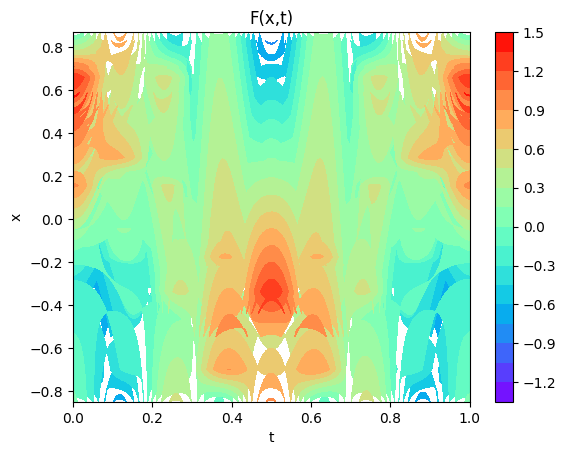

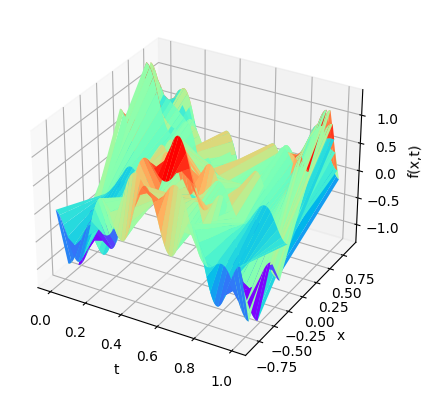

In [21]:
plot3D(x_test.squeeze().detach(), t_test, y_test)
out = model(x_test).reshape(shape=x_test.shape).squeeze().detach()
plot3D(x_test.squeeze().detach(), t_test, out)

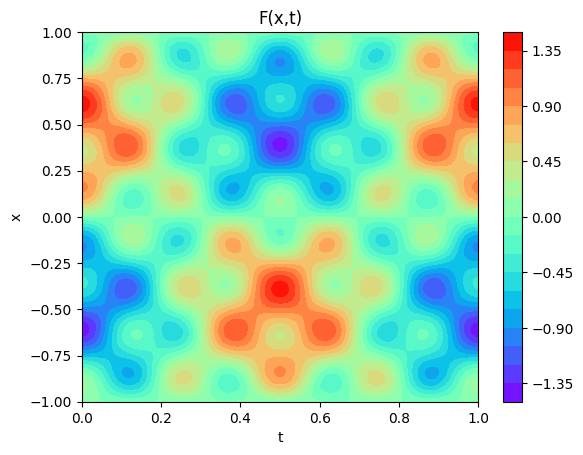

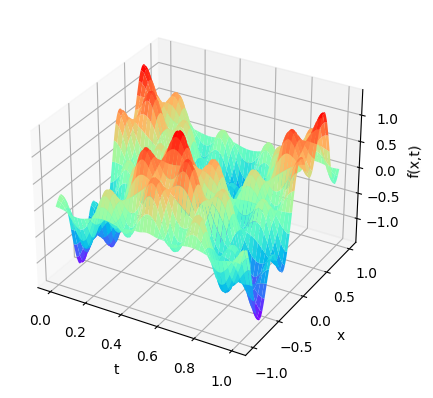

In [26]:
out = model(x_data.unsqueeze(dim = -1)).reshape(shape=x_data.shape).squeeze().detach()
plot3D(x_data.squeeze().detach(), t_data, out)